# Explore the Caravan-Qual dataset!

#### Author: Edward Jones (e.r.jones@uu.nl)

This notebook provides an introduction to _Caravan-Qual_, an open source large sample hydrology and water quality dataset. The dataset contains streamflow and river water quality observations, which can be connected to catchment characteristics, meteorological forcing and process-based hydrological model output:
- **River water quality observations** from various datasets, primarily global (e.g. _GEMS_) to national databases (e.g. _Water Quality Portal_)
- **Streamflow observations** from various datasets, primarily those included in _Caravan_ and its associated extensions.
- **Catchment attributes** from _HydroATLAS_
- **Stream attributes** from _GEOGLOWSv2_
- **Weather data** from _ERA5-Land_

All data is stored in Zarr format.

Please note Caravan-Qual comes in a "full" and a "lite" version. In the "lite" version, weather data is provided in a different Zarr and at monthly resolution (instead of daily).

## 1. Setup

In [18]:
#load required modules
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("Modules loaded!")

Modules loaded!


In [39]:
#Caravan-Qual dataset
data_dir = Path("D:/Caravan-Qual")
VERSION = "full" #"lite" or "full"

if VERSION == "full":
    zarr_main = data_dir / "Caravan-Qual.zarr"
    zarr_weather = zarr_main #daily weather variables within main zarr

if VERSION == "lite":
    zarr_main = data_dir / "Caravan-Qual_lite.zarr"
    zarr_weather = data_dir / "Caravan-Qual_monthly_weather.zarr" #monthly weather variables

linkages_main = data_dir / "Caravan-Qual_linkages.parquet"
variable_metadata = data_dir / "Caravan-Qual_zarr_variables.csv"

#plotting paths
plot_dir = data_dir / "example_plots"
os.makedirs(plot_dir, exist_ok=True)

print("Directories and files defined!")

Directories and files defined!


In [40]:
# Define plotting preferences
plt.style.use('default')
%matplotlib inline

plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.grid': True,
    'grid.alpha': 0.2,
    'grid.linestyle': '-',
    'grid.linewidth': 0.5,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'figure.titlesize': 16,
    'figure.titleweight': 'bold',
})

print("Plotting preferences assigned!")

Plotting preferences assigned!


## 2. Load datasets

In [41]:
print("Loading main dataset...")
ds = xr.open_zarr(zarr_main, consolidated=True)
var_metadata = pd.read_csv(variable_metadata)

print("Loading weather dataset...")
if VERSION == "full":
    print("Loading Caravan-Qual...")
    ds_weather = ds
elif VERSION == "lite":
    print("Loading Caravan-Qual-lite...")
    ds_weather = xr.open_zarr(zarr_weather, consolidated=True)
else:
    raise ValueError(f"Unknown DATASET_VERSION: {VERSION}. Use 'lite' or 'full'.")

print("\nLoading linkage files...")
df_main_linkages = pd.read_parquet(linkages_main)
print(df_main_linkages.head())

print("All datasets loaded successfully!")

Loading main dataset...
Loading weather dataset...
Loading Caravan-Qual...

Loading linkage files...
         wqms_id  wqms_lat  wqms_lon country_name  hydrobasin_level12  \
0  wqms_00500001  42.24956  19.34944      Albania          2120598220   
1  wqms_00500002  42.17353  19.30196      Albania          2120599280   
2  wqms_00500003  41.96908  19.38477      Albania          2120011990   
3  wqms_00500004  41.91697  19.36187      Albania          2120011990   
4  wqms_00500005  40.45269  19.57819      Albania          2120632170   

      LINKNO  merged_LINKNO gauge_id  gauge_distance_km  total_observations  \
0  210391046      210389990     None                NaN                 231   
1  210254827      210254827     None                NaN                 231   
2  210423797      210463919     None                NaN                  84   
3  210378390      210463919     None                NaN                 258   
4  210261259      210292941     None                NaN          

## 3. Basic overview of _Caravan-WQMS_

In [22]:
#Structure of dataset and time range
print(f"\nDimensions: {dict(ds.sizes)}")
print(f"\nTime range: {pd.to_datetime(ds.time.values[0]).strftime('%d-%m-%Y')} to {pd.to_datetime(ds.time.values[-1]).strftime('%d-%m-%Y')}")

data_vars = list(ds.data_vars)

print("\nVariables:")
for category in var_metadata['category'].unique():
    count = len(var_metadata[var_metadata['category'] == category])
    print(f"  - {category}: {count}")



Dimensions: {'LINKNO': 85358, 'wqms_id': 137373, 'time': 16710, 'gauge_id': 25837}

Time range: 01-01-1980 to 30-09-2025

Variables:
  - catchment_attributes: 197
  - metadata: 11
  - stream_attributes: 8
  - water_quality: 100
  - water_quantity: 1
  - weather: 23


## 4. Spatial distribution of monitoring stations

### 4.1 Global outlook

Extracting station locations...
Plotting gauge stations and water quality monitoring stations...


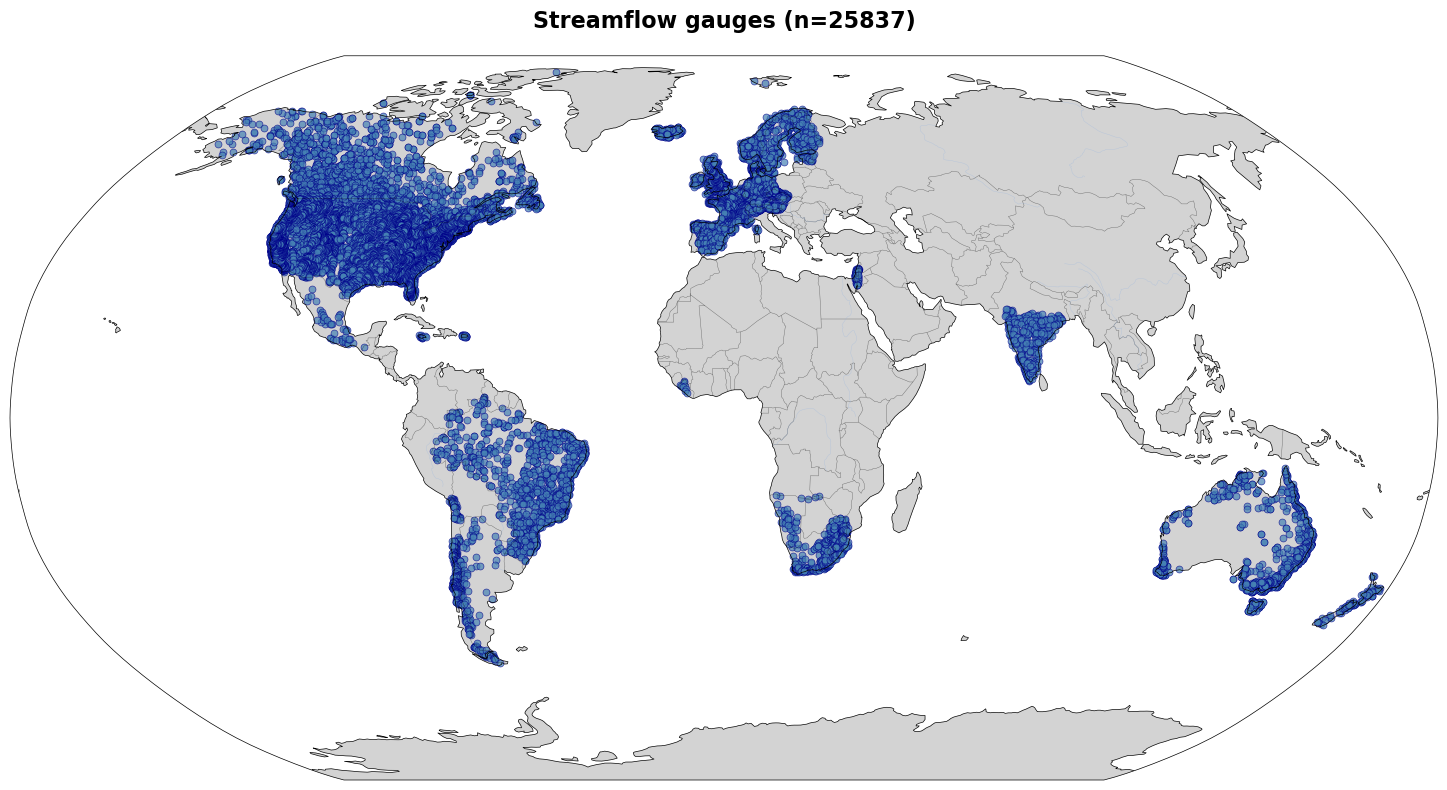

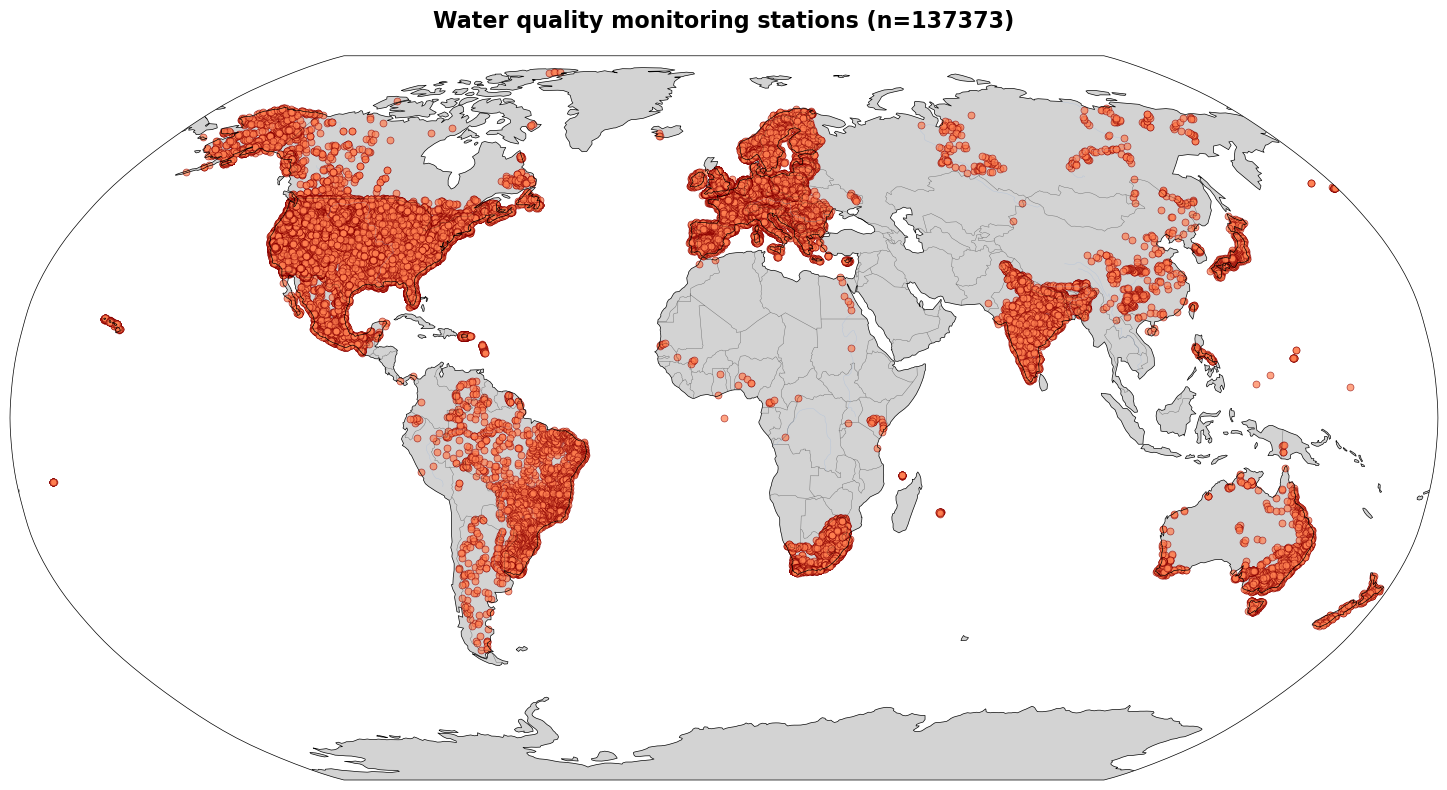

In [23]:
#Extract station locations from linkages
print("Extracting station locations...")
wqms_ids = df_main_linkages['wqms_id'].unique()

#Water quality monitoring stations
wqms_lats = ds['wqms_lat'].values
wqms_lons = ds['wqms_lon'].values

#Streamflow gauges
sf_lats = ds['gauge_lat'].values
sf_lons = ds['gauge_lon'].values

# Plots
station_types = [
    {'lons': sf_lons, 'lats': sf_lats, 'color': 'steelblue',
     'edgecolor': 'darkblue', 'title': 'Streamflow gauges', 'filename': 'streamflow_gauges_map.png'},
    {'lons': wqms_lons, 'lats': wqms_lats, 'color': 'coral',
     'edgecolor': 'darkred', 'title': 'Water quality monitoring stations', 'filename': 'water_quality_stations_map.png'}
]

print("Plotting gauge stations and water quality monitoring stations...")
for station in station_types:
    fig = plt.figure(figsize=(16, 8))
    ax = plt.axes(projection=ccrs.Robinson())

    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='none')
    ax.add_feature(cfeature.OCEAN, facecolor='white', edgecolor='none')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.5)
    ax.add_feature(cfeature.RIVERS, linewidth=0.3, alpha=0.5)

    #Plot stations
    ax.scatter(station['lons'], station['lats'], c=station['color'], s=25, alpha=0.7, transform=ccrs.PlateCarree(),edgecolors=station['edgecolor'], linewidth=0.5)

    ax.set_global()
    ax.set_title(f"{station['title']} (n={len(station['lats'])})", fontsize=16, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, station['filename']), dpi=300, bbox_inches='tight')
    plt.show()


### 4.2 Regional outlook

Plotting gauge stations and water quality monitoring stations for The British Isles...


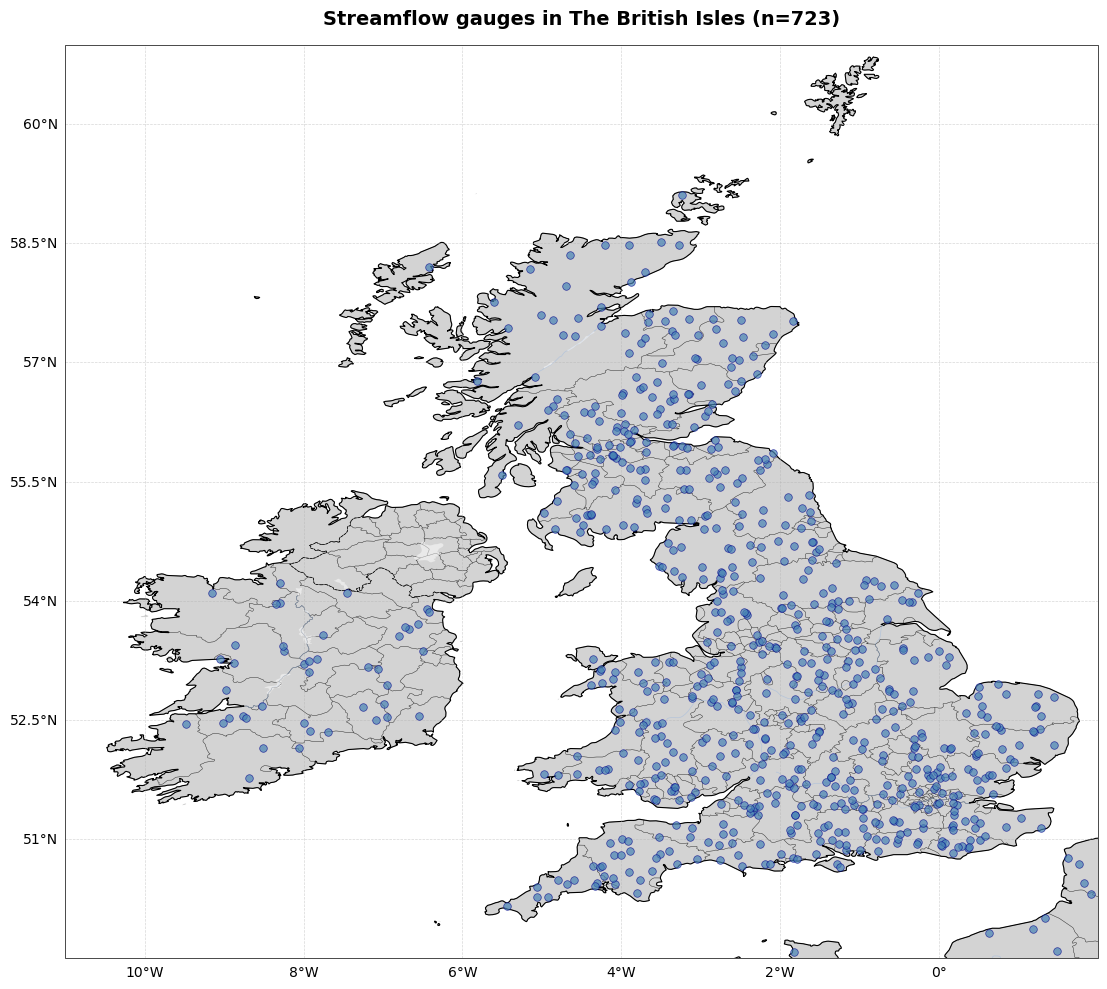

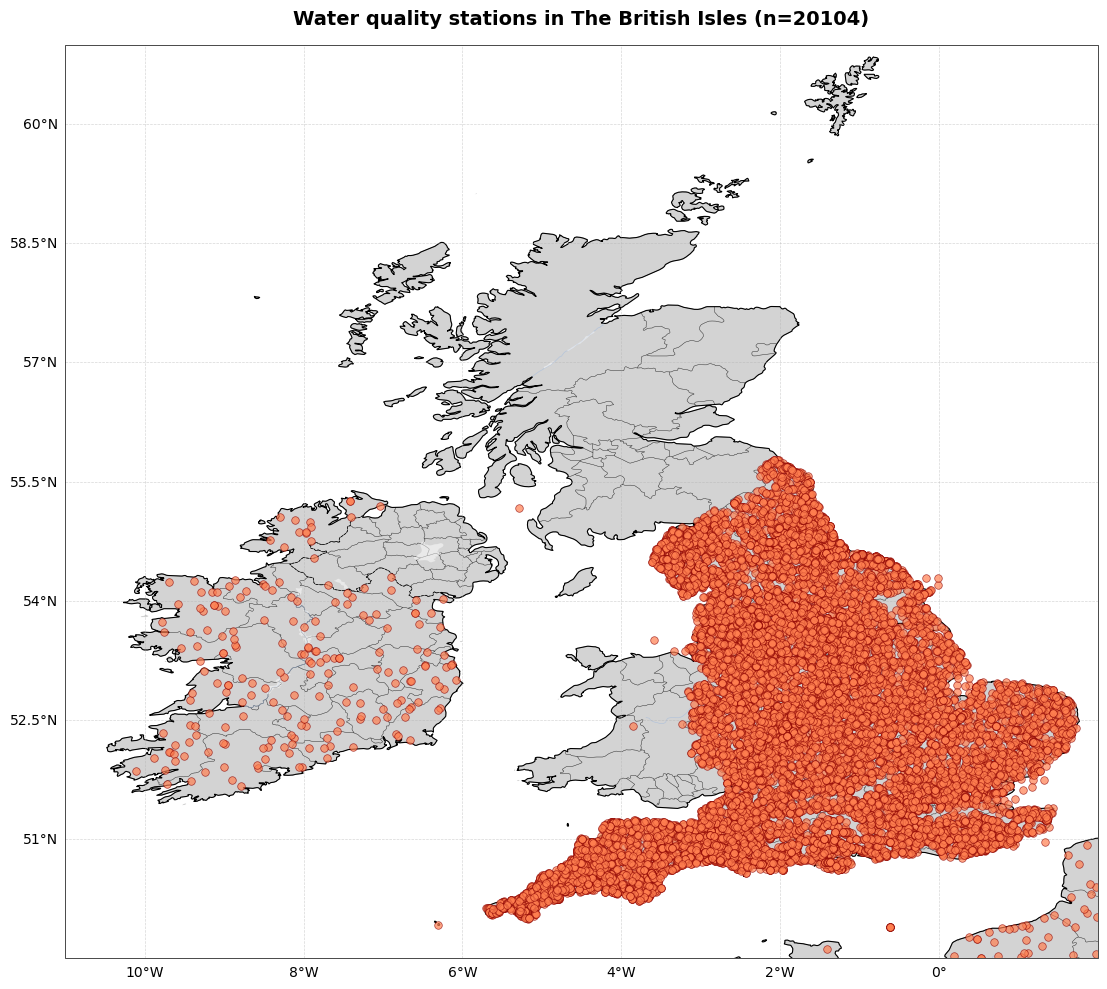

In [24]:
# Define bounding box and region name
#bbox = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 50}
#region_name = 'United States of America'

bbox = {'lon_min': -11, 'lon_max': 2, 'lat_min': 49.5, 'lat_max': 61}
region_name = 'The British Isles'

#Filter stations
wqms_in_bbox = (
    (wqms_lons >= bbox['lon_min']) & (wqms_lons <= bbox['lon_max']) &
    (wqms_lats >= bbox['lat_min']) & (wqms_lats <= bbox['lat_max'])
)

sf_in_bbox = (
    (sf_lons >= bbox['lon_min']) & (sf_lons <= bbox['lon_max']) &
    (sf_lats >= bbox['lat_min']) & (sf_lats <= bbox['lat_max'])
)

# Regional maps
station_types = [
    {'lons': sf_lons[sf_in_bbox], 'lats': sf_lats[sf_in_bbox],
     'color': 'steelblue', 'edgecolor': 'darkblue', 'title': 'Streamflow gauges', 'filename': 'regional_streamflow_stations_map.png'},
    {'lons': wqms_lons[wqms_in_bbox], 'lats': wqms_lats[wqms_in_bbox],
     'color': 'coral', 'edgecolor': 'darkred', 'title': 'Water quality stations', 'filename': 'regional_water_quality_stations_map.png'},
]

print(f"Plotting gauge stations and water quality monitoring stations for {region_name}...")
for station in station_types:
    fig = plt.figure(figsize=(14, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set extent
    ax.set_extent([bbox['lon_min'], bbox['lon_max'], bbox['lat_min'], bbox['lat_max']],
                  crs=ccrs.PlateCarree())

    # Add map features
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='none')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='--')
    ax.add_feature(cfeature.STATES, linewidth=0.3, alpha=0.5)
    ax.add_feature(cfeature.RIVERS, linewidth=0.5, alpha=0.5)
    ax.add_feature(cfeature.LAKES, facecolor='white', alpha=0.5)

    # Plot stations
    ax.scatter(station['lons'], station['lats'],
               c=station['color'], s=30, alpha=0.7,
               transform=ccrs.PlateCarree(),
               edgecolors=station['edgecolor'], linewidth=0.5, zorder=5)

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    ax.set_title(f'{station["title"]} in {region_name} (n={len(station["lats"])})',
                 fontsize=14, fontweight='bold', pad=15)

    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, station['filename']), dpi=300, bbox_inches='tight')
    plt.show()

## 5. Time series data (example water quality station)

In [34]:
# Select an example WQMS station
wqms_ids = ds.coords['wqms_id'].values
example_wqms = "wqms_16500093" #specify a station, or pick a station from wqms_ids

print(f"Selected water quality station: {example_wqms}")

Selected water quality station: wqms_16500093


### 5.1 Water quality data: summarise at station level and plot time series

In [26]:
# Get all water quality parameters available for this station
wq_params = var_metadata[var_metadata['category'] == 'water_quality']['variable'].tolist()

# Extract data for parameters with observations
wq_data = {}
for param in wq_params:
    if param in ds.data_vars:  # Check if variable exists in dataset
        data = ds[param].sel(wqms_id=example_wqms)
        if np.sum(~np.isnan(data.values)) > 0:
            wq_data[param] = data

print(f"\nWater quality parameters with data: {len(wq_data)}")
for param in list(wq_data.keys())[:10]:  # Show first 10
    n_obs = np.sum(~np.isnan(wq_data[param].values))
    print(f"  - {param}: {n_obs} observations")
if len(wq_data) > 10:
    print(f"  ... and {len(wq_data) - 10} more parameters")


Water quality parameters with data: 18
  - DIP: 712 observations
  - DO: 5643 observations
  - DOC: 1981 observations
  - DOSAT: 86 observations
  - NH4N: 5731 observations
  - NO2N: 558 observations
  - NO3N: 5688 observations
  - pH: 5457 observations
  - PN: 90 observations
  - POC: 103 observations
  ... and 8 more parameters


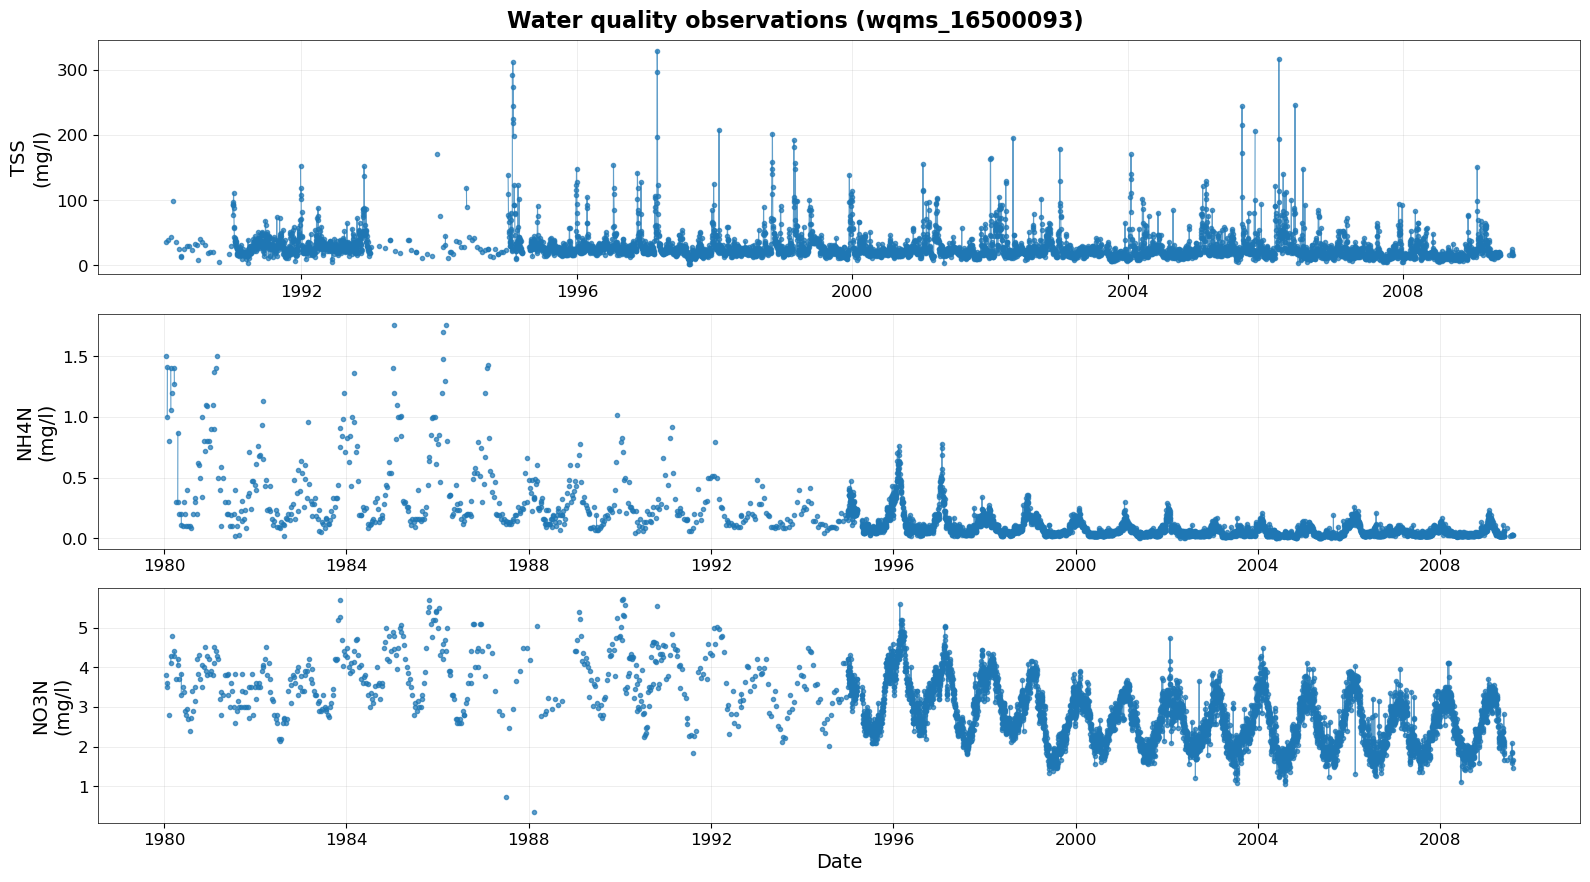

In [27]:
# Plot (up to) n_plots parameters with the highest number of observations
n_plots = 3
#n_plots = len(wq_data)
params_to_plot = sorted(wq_data.keys(),
                       key=lambda x: wq_data[x].to_pandas().notna().sum(),
                       reverse=True)[:n_plots]

fig, axes = plt.subplots(len(params_to_plot), 1, figsize=(16, 3*len(params_to_plot)))
if len(params_to_plot) == 1:
    axes = [axes]

for idx, param in enumerate(params_to_plot):
    data_df = wq_data[param].to_pandas()
    axes[idx].plot(data_df.index, data_df.values, 'o-',
                   linewidth=0.8, markersize=3, alpha=0.7)

    # Get units from attributes
    units = wq_data[param].attrs.get('units', 'unknown')

    axes[idx].set_ylabel(f'{param.replace("qual_", "")}\n({units})')
    axes[idx].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date')
fig.suptitle(f'Water quality observations ({example_wqms})', y=0.975)

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'example_wq_data.png'), dpi=300, bbox_inches='tight')
plt.show()

### 5.2 Linking water quality data to streamflow

Distance threshold for matching to gauge station: 50.0 km
Checking for linked gauge station...
✓ Found linked gauge: grdc_6335020 (distance: 34.30 km)

Streamflow Statistics:
  Streamflow observations: 14,976 (89.6% of full time period)
  Mean: 2321.79 m³/s
  Median: 2002.39 m³/s
  Min: 698.08 m³/s
  Max: 11297.87 m³/s


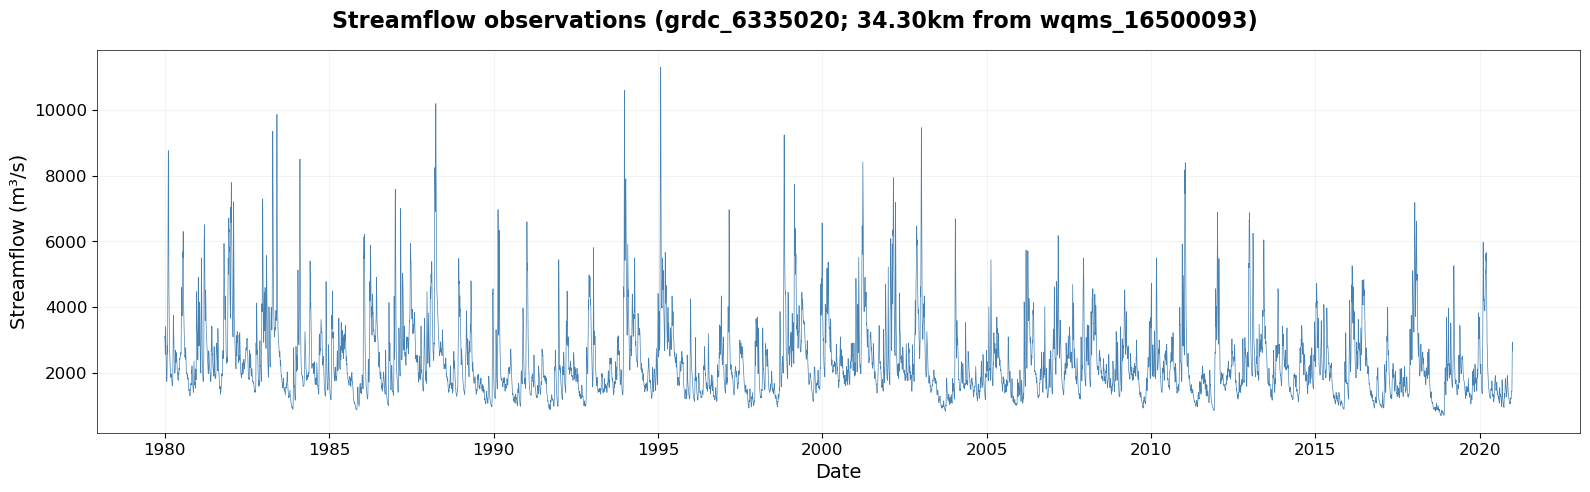

In [28]:
# Set distance threshold for matching to streamflow gauge
distance_threshold_km = 50.0
print(f"Distance threshold for matching to gauge station: {distance_threshold_km} km")
print("Checking for linked gauge station...")

# Get station info
station_row = df_main_linkages[df_main_linkages['wqms_id'] == example_wqms]

if len(station_row) > 0:
    has_gauge = station_row['has_streamflow'].values[0]

    if has_gauge:
        actual_distance = station_row['gauge_distance_km'].values[0]
        linked_gauge = station_row['gauge_id'].values[0]

        if actual_distance <= distance_threshold_km:
            print(f"✓ Found linked gauge: {linked_gauge} (distance: {actual_distance:.2f} km)")

            # Check if streamflow data available in zarr
            if linked_gauge in ds.coords['gauge_id'].values:
                streamflow = ds['streamflow'].sel(gauge_id=linked_gauge)
                streamflow_df = streamflow.to_pandas()
                valid_data = streamflow_df.dropna()

                print(f"\nStreamflow Statistics:")
                print(f"  Streamflow observations: {len(valid_data):,} ({100*len(valid_data)/len(streamflow_df):.1f}% of full time period)")
                print(f"  Mean: {valid_data.mean():.2f} m³/s")
                print(f"  Median: {valid_data.median():.2f} m³/s")
                print(f"  Min: {valid_data.min():.2f} m³/s")
                print(f"  Max: {valid_data.max():.2f} m³/s")

                if len(valid_data) > 0:
                    # Plot streamflow time series
                    fig, ax = plt.subplots(figsize=(16, 5))

                    ax.plot(streamflow_df.index, streamflow_df.values, color='steelblue')
                    ax.set_xlabel('Date')
                    ax.set_ylabel('Streamflow (m³/s)')
                    fig.suptitle(f'Streamflow observations ({linked_gauge}; {actual_distance:.2f}km from {example_wqms})', y=0.975)

                    plt.tight_layout()
                    plt.savefig(os.path.join(plot_dir, 'example_streamflow_data.png'), dpi=300, bbox_inches='tight')
                    plt.show()
                else:
                    print(f"    No valid streamflow data available for {linked_gauge}")
            else:
                print(f"    Gauge {linked_gauge} not found in streamflow dataset")
        else:
            print(f"    No gauge found within {distance_threshold_km} km threshold" )
            print(f"    Nearest gauge ({linked_gauge}) is {actual_distance:.2f} km away")
    else:
        print(f"    No linked gauge station found for this wqms_id")
else:
    print(f"    Water quality monitoring station {example_wqms} not found")

### 5.3 Linking water quality observations to weather data (ERA5-land)

Checking for linked weather data (i.e. LINKNO)...
  Found LINKNO: 230557491
  Available variables: 23


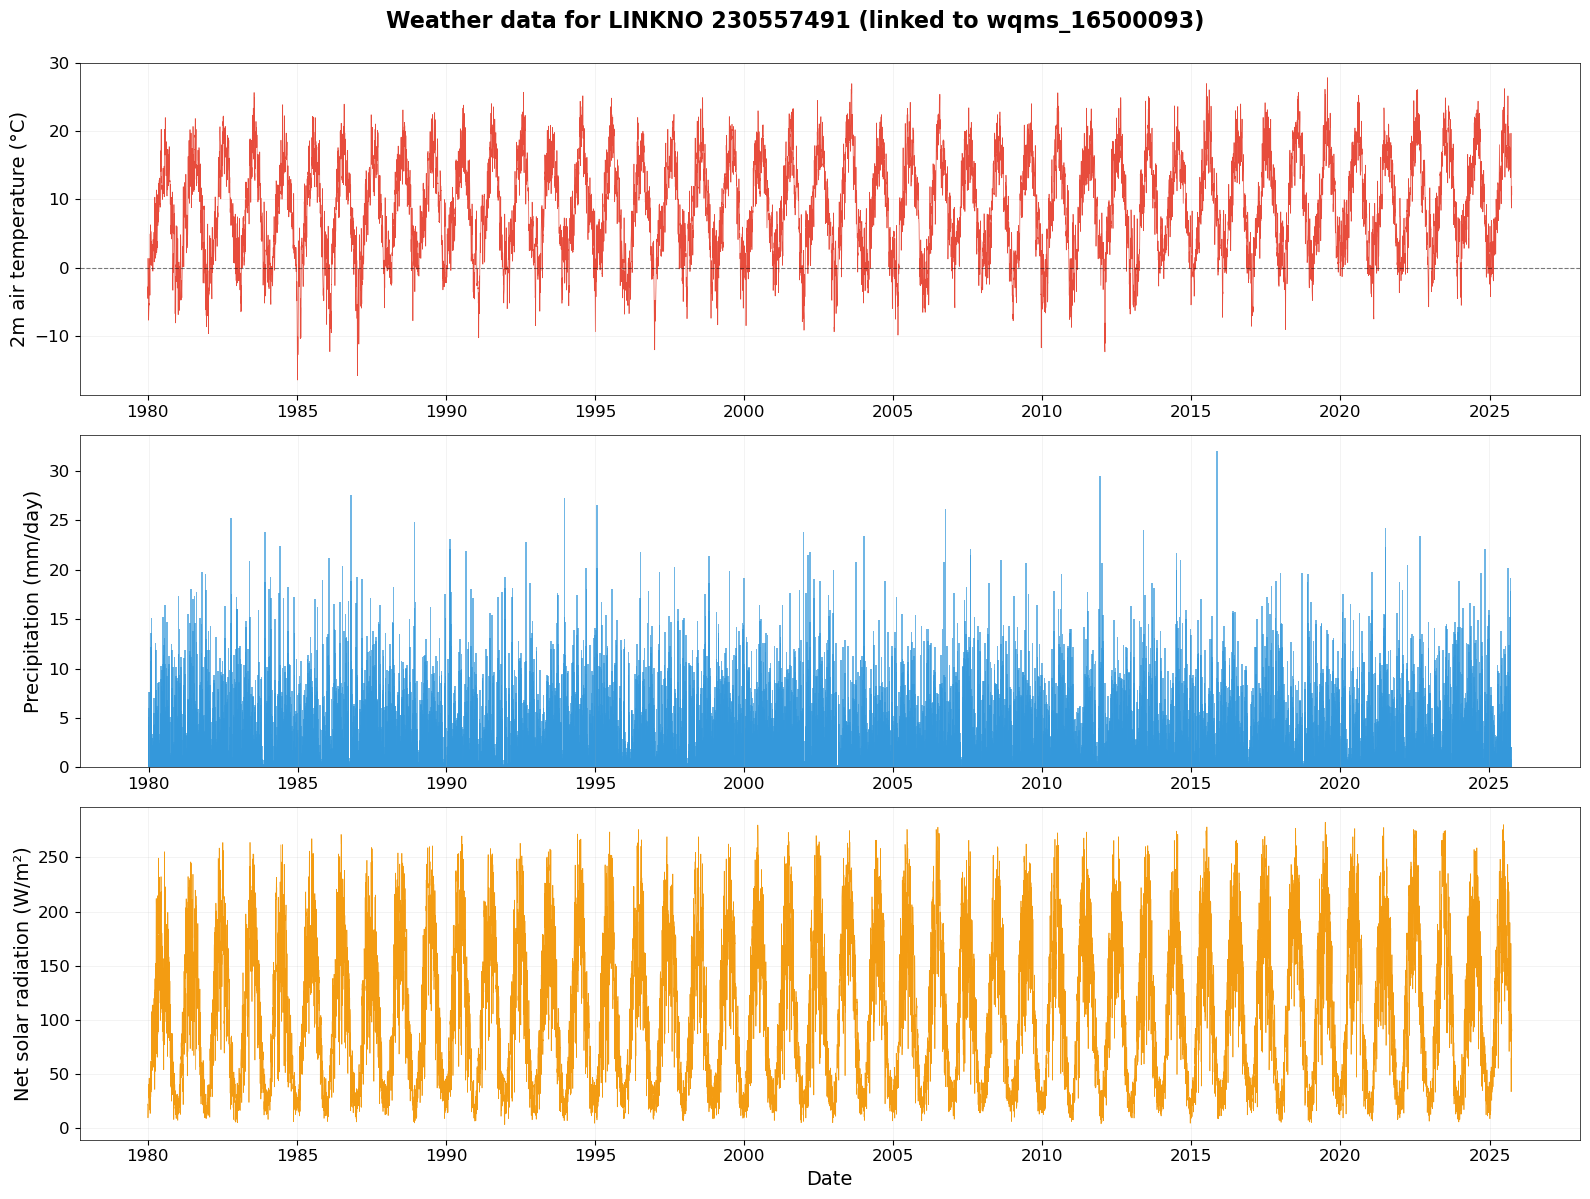

In [42]:
print("Checking for linked weather data (i.e. LINKNO)...")
linkage = df_main_linkages[df_main_linkages['wqms_id'] == example_wqms]

if len(linkage) > 0:
    linkno = linkage['LINKNO'].values[0]
    print(f"  Found LINKNO: {linkno}")

    # Check if weather data available
    if linkno in ds_weather.coords['LINKNO'].values:
        # Get weather variables from metadata
        weather_vars_to_plot = [
            'temperature_2m_mean',
            'total_precipitation_sum',
            'surface_net_solar_radiation_mean'
        ]

        weather_data = {}
        all_weather_vars = var_metadata[var_metadata['category'] == 'weather']['variable'].tolist()
        print(f"  Available variables: {len(all_weather_vars)}")

        for var in all_weather_vars:
            if var in ds_weather.data_vars:  # Check if variable exists
                data = ds_weather[var].sel(LINKNO=linkno)
                n_obs = np.sum(~np.isnan(data.values))

                if n_obs > 0:
                    weather_data[var] = data
                    pct = 100 * n_obs / len(data.values)

        if len(weather_data) > 0:
            # Plot weather variables
            fig, axes = plt.subplots(3, 1, figsize=(16, 12))

            # Temperature
            if 'temperature_2m_mean' in weather_data:
                temp_df = weather_data['temperature_2m_mean'].to_pandas()
                axes[0].plot(temp_df.index, temp_df.values, color='#e74c3c')
                axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
                axes[0].set_ylabel('2m air temperature (°C)')

            # Precipitation
            if 'total_precipitation_sum' in weather_data:
                precip_df = weather_data['total_precipitation_sum'].to_pandas()
                axes[1].bar(precip_df.index, precip_df.values, width=20, color='#3498db', alpha=0.7, edgecolor='none')
                precip_time_unit = "day" if VERSION == "full" else "month"
                axes[1].set_ylabel(f'Precipitation (mm/{precip_time_unit})')
                axes[1].grid(axis='y')

            # Solar Radiation
            if 'surface_net_solar_radiation_mean' in weather_data:
                solar_df = weather_data['surface_net_solar_radiation_mean'].to_pandas()
                axes[2].plot(solar_df.index, solar_df.values, color='#f39c12')
                axes[2].set_ylabel('Net solar radiation (W/m²)')
                axes[2].set_xlabel('Date')

            fig.suptitle(f'Weather data for LINKNO {linkno} (linked to {example_wqms})', y=0.995)
            plt.tight_layout()
            plt.savefig(os.path.join(plot_dir, 'example_weather_data.png'), dpi=300, bbox_inches='tight')
            plt.show()
        else:
            print(f"    No weather data available for LINKNO {linkno}")
    else:
        print(f"    LINKNO {linkno} not found in dataset")
else:
    print(f"    No LINKNO found for {example_wqms}")

## 6. Aggregated analysis of _Caravan-WQMS_ (full database interactions)

### 6.1 Detailed inspection of _Caravan-WQMS_

#### 6.1.1 Number of observations per water quality constituent

In [13]:
# Display all available water quality parameters from metadata
available_params = [col.replace('obs_', '') for col in df_main_linkages.columns if col.startswith('obs_')]

print(f"Available water quality parameters ({len(available_params)} total):\n")
print(f"{'Rank':<6} {'Parameter':<30} {'# Stations':<15} {'Total Observations':>20}")
print("=" * 73)

param_stats = []
for param in available_params:
    n_stations = (df_main_linkages[f'obs_{param}'] > 0).sum()
    total_obs = df_main_linkages[f'obs_{param}'].sum()
    param_stats.append((param, n_stations, total_obs))

# Sort by total observations (descending)
param_stats.sort(key=lambda x: x[2], reverse=True)

for i, (param, n_stations, total_obs) in enumerate(param_stats, 1):
    print(f"{i:<6} {param:<30} {n_stations:<15,.0f} {total_obs:>20,.0f}")


Available water quality parameters (100 total):

Rank   Parameter                      # Stations        Total Observations
1      TEMP                           91,048                     9,956,239
2      EC                             80,366                     8,005,025
3      pH                             85,879                     3,754,745
4      DO                             62,611                     2,677,389
5      NO3N                           54,859                     2,290,477
6      DOSAT                          52,619                     2,255,382
7      NO2N                           49,773                     2,138,736
8      TRP                            42,721                     2,074,253
9      TP                             49,162                     1,897,376
10     TSS                            37,727                     1,675,844
11     BOD5                           26,780                     1,218,434
12     TN                             33,885       

#### 6.1.2 Geographic distribution of observations (country-level)

In [14]:
country_stats = df_main_linkages.groupby('country_name').agg({
    'wqms_id': 'count',
    'total_observations': 'sum',
    'parameters_measured': 'mean'
}).rename(columns={
    'wqms_id': 'n_stations',
    'total_observations': 'total_obs',
    'parameters_measured': 'avg_params'
}).sort_values('total_obs', ascending=False)

print(f"\nTop 20 countries by total observations:")
print(f"{'Rank':<6} {'Country':<30} {'Stations':<12} {'Total Obs':>15} {'Avg Params':>12}")
print("=" * 80)
for i, (country, row) in enumerate(country_stats.head(20).iterrows(), 1):
    print(f"{i:<6} {country:<30} {row['n_stations']:<12,.0f} {row['total_obs']:>15,.0f} {row['avg_params']:>12.1f}")


Top 20 countries by total observations:
Rank   Country                        Stations           Total Obs   Avg Params
1      United Kingdom                 19,863            18,825,489         16.3
2      United States of America       74,494            14,435,221          9.5
3      Australia                      2,135             10,424,395          3.7
4      France                         4,405              2,802,181         22.7
5      Italy                          4,318              2,039,827         25.2
6      Mexico                         2,143              2,030,445         28.8
7      South Africa                   4,479              1,985,323          3.1
8      India                          2,496              1,840,883         12.7
9      Switzerland                    281                1,426,561         10.5
10     Poland                         4,441              1,358,056         18.2
11     Germany                        1,944              1,245,747          8.1

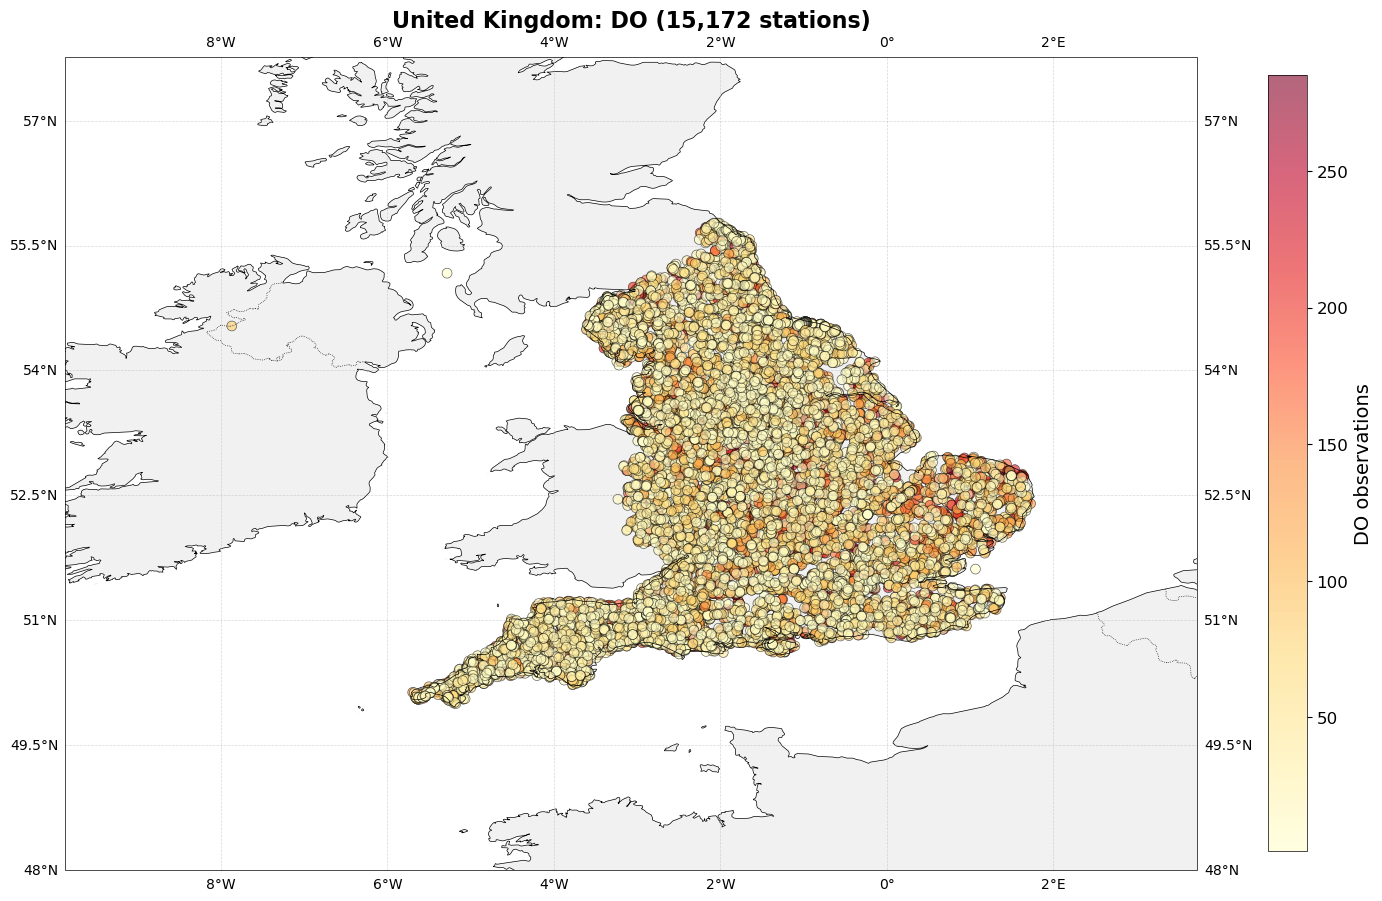


Summary
Total stations:                         15,172
Total observations:                  1,263,383
Mean obs per station:                       83
Median obs per station:                     58
Min obs:                                     1
Max obs:                                   496
Earliest observation:               2000-01-01
Latest observation:                 2025-08-06
Mean monitoring period (yrs):             10.6


In [15]:
selected_country = "United Kingdom"
selected_param = "DO"

# Filter data
country_data = df_main_linkages[
    (df_main_linkages['country_name'] == selected_country) &
    (df_main_linkages[f'obs_{selected_param}'] > 0)
].copy()

if len(country_data) > 0:
    # Create map
    fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

    # Set extent and add features
    buffer = 2
    ax.set_extent([country_data['wqms_lon'].min() - buffer, country_data['wqms_lon'].max() + buffer,
                   country_data['wqms_lat'].min() - buffer, country_data['wqms_lat'].max() + buffer])
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
    ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')

    # Plot stations
    scatter = ax.scatter(country_data['wqms_lon'], country_data['wqms_lat'],
                        c=country_data[f'obs_{selected_param}'], s=50, alpha=0.6,
                        cmap='YlOrRd', edgecolors='black', linewidths=0.5,
                        transform=ccrs.PlateCarree(),
                        vmax=country_data[f'obs_{selected_param}'].quantile(0.99))

    plt.colorbar(scatter, ax=ax, label=f'{selected_param} observations', shrink=0.8)
    ax.set_title(f'{selected_country}: {selected_param} ({len(country_data):,} stations)')
    plt.tight_layout()
    plt.show()

    # Add a summary table
    print(f"\nSummary")
    print("=" * 46)

    country_data['obs_param'] = country_data[f'obs_{selected_param}']
    print(f"Total stations:                {len(country_data):>15,.0f}")
    print(f"Total observations:            {country_data['obs_param'].sum():>15,.0f}")
    print(f"Mean obs per station:          {country_data['obs_param'].mean():>15,.0f}")
    print(f"Median obs per station:        {country_data['obs_param'].median():>15,.0f}")
    print(f"Min obs:                       {country_data['obs_param'].min():>15,.0f}")
    print(f"Max obs:                       {country_data['obs_param'].max():>15,.0f}")

    # Temporal coverage
    country_data['param_duration'] = (
        pd.to_datetime(country_data[f'end_{selected_param}']) -
        pd.to_datetime(country_data[f'start_{selected_param}'])
    ).dt.days / 365.25

    print(f"Earliest observation:          {pd.to_datetime(country_data[f'start_{selected_param}']).min().strftime('%Y-%m-%d'):>15}")
    print(f"Latest observation:            {pd.to_datetime(country_data[f'end_{selected_param}']).max().strftime('%Y-%m-%d'):>15}")
    print(f"Mean monitoring period (yrs):  {country_data['param_duration'].mean():>15.1f}")

else:
    print(f"No stations found for {selected_country} measuring {selected_param}")



#### 6.1.3 Linkages between water quality and streamflow

In [16]:
# Check availability of linked streamflow data at different distances
distance_thresholds_km = [1, 5, 10, 25, 50, 100]

# Calculate total observations across all stations
total_all_obs = df_main_linkages['total_observations'].sum()
print(total_all_obs)

print("Displaying statistics of matched water quality stations and streamflow gauges...")
print(f"\n{'Distance':<10} {'Stations':<12} {'% Stations':<12}   {'Linked Obs':<15} {'% obs matched':>5}")
print("=" * 70)

for threshold in distance_thresholds_km:
    linked = df_main_linkages[
        (df_main_linkages['has_streamflow']) &
        (df_main_linkages['gauge_distance_km'] <= threshold)
    ]
    n_stations = len(linked)
    pct_stations = 100 * n_stations / len(df_main_linkages)
    total_obs = linked['total_observations'].sum()
    pct_obs = 100 * total_obs / total_all_obs

    print(f"≤{threshold:>3} km     {n_stations:<12,.0f} {pct_stations:>6.1f}%       {total_obs:<15,.0f} {pct_obs:>5.1f}%")

64275661
Displaying statistics of matched water quality stations and streamflow gauges...

Distance   Stations     % Stations     Linked Obs      % obs matched
≤  1 km     13,545          9.9%       12,660,213       19.7%
≤  5 km     22,037         16.0%       16,624,432       25.9%
≤ 10 km     29,590         21.5%       20,017,794       31.1%
≤ 25 km     40,036         29.1%       24,928,542       38.8%
≤ 50 km     45,103         32.8%       27,571,663       42.9%
≤100 km     48,401         35.2%       29,369,743       45.7%


### 6.2 Time-series per water quality parameter


Extracting TEMP data for top stations...
Successfully loaded data for 5 stations


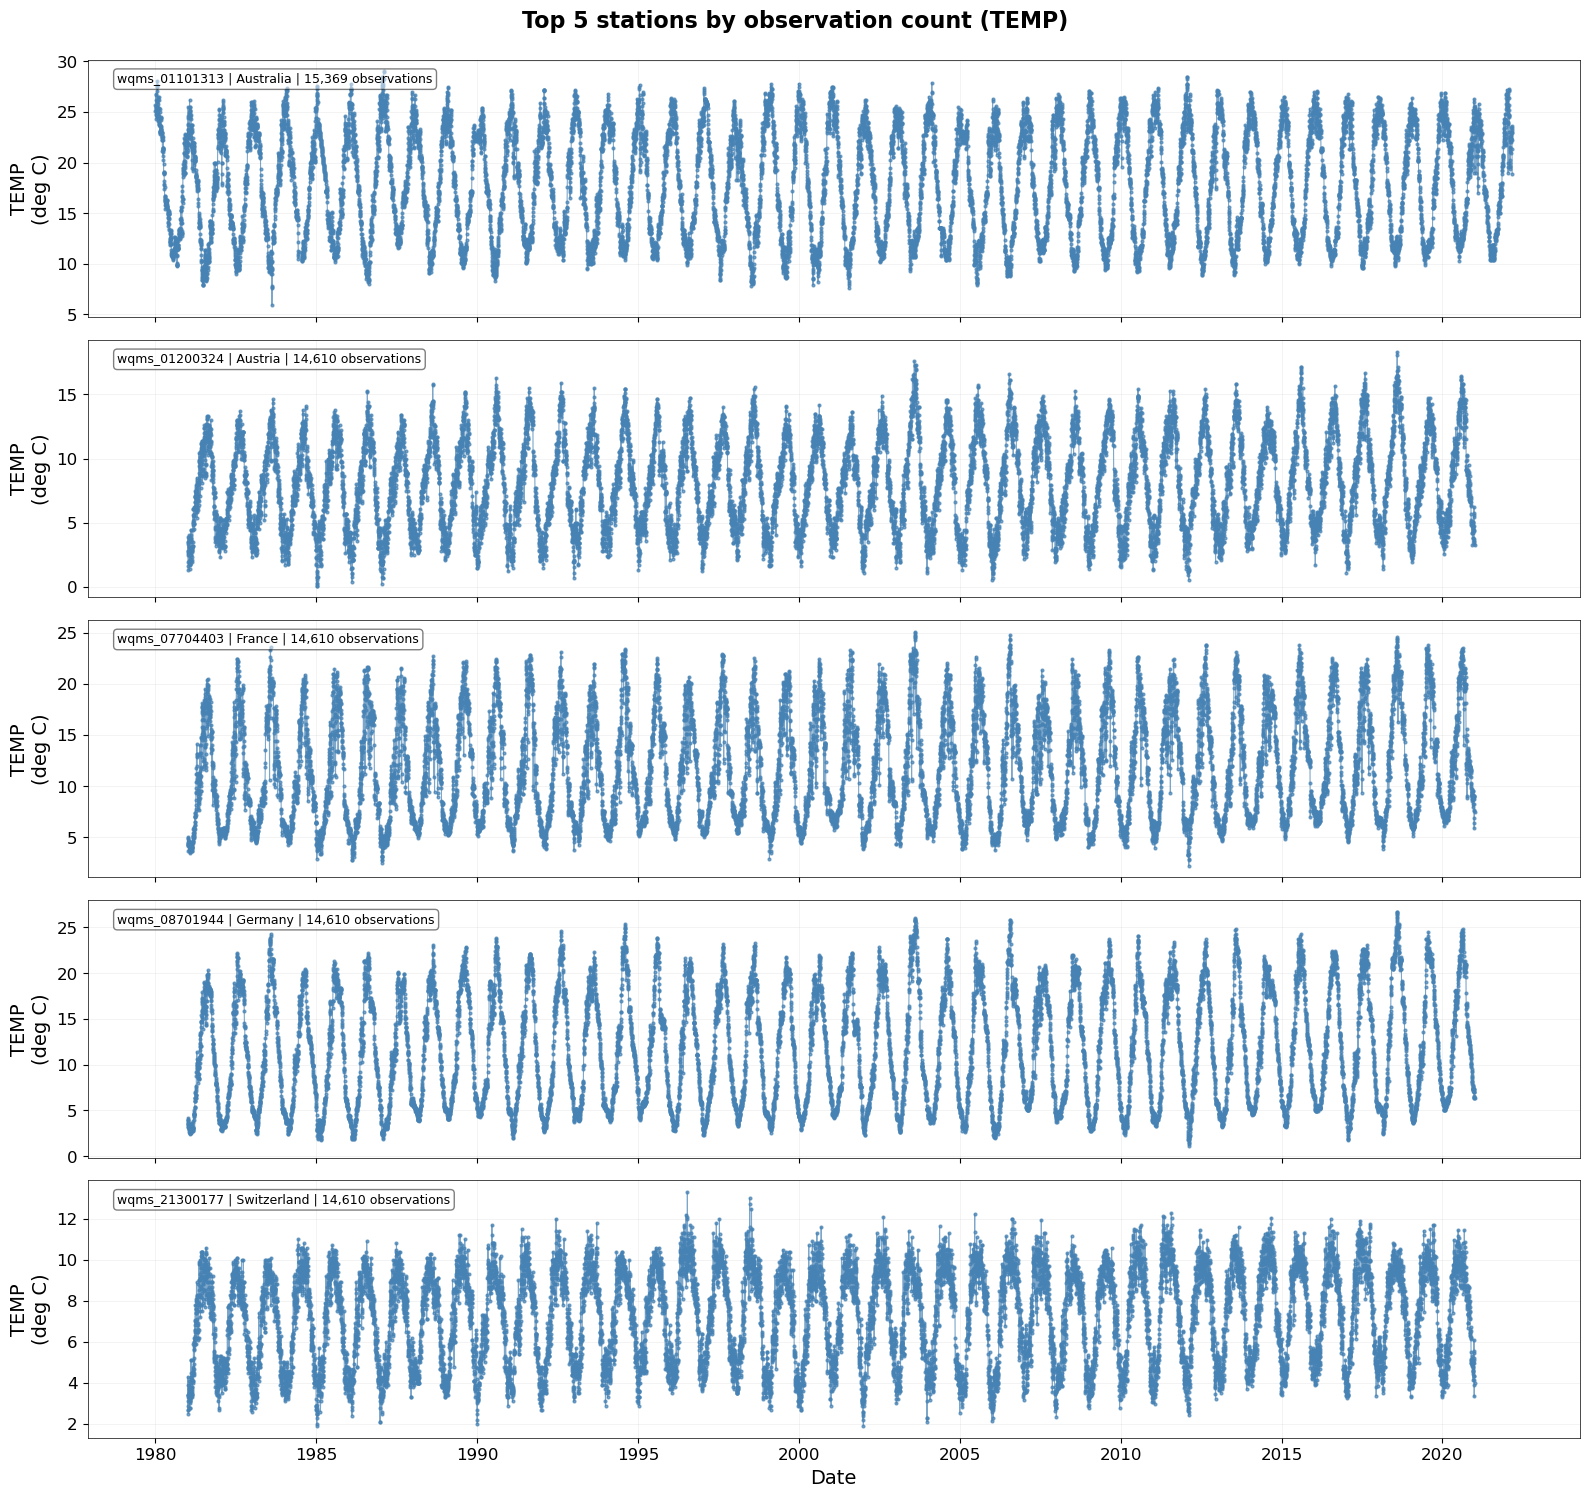

In [17]:
#Make plot for the stations with the most observations for a given parameter
wq_parameter = "TEMP"
obs_col = f'obs_{wq_parameter}'
param = f'{wq_parameter}'

n_top_stations = 5  # Number of stations to plot

if obs_col not in df_main_linkages.columns:
    available_params = [col.replace('obs_', '') for col in df_main_linkages.columns if col.startswith('obs_')]
    print(f"Error: Parameter '{wq_parameter}' not found in dataset")
    print(f"Available parameters: {', '.join(available_params[:20])}...")
else:
    # Find top N stations by observation count for this parameter
    top_stations = df_main_linkages.nlargest(n_top_stations, obs_col)[
        ['wqms_id', obs_col, 'country_name', 'wqms_lat', 'wqms_lon',
         f'start_{wq_parameter}', f'end_{wq_parameter}']
    ].copy()

    # Extract data for top stations
    print(f"\nExtracting {wq_parameter} data for top stations...")
    station_data = {}

    for _, station in top_stations.iterrows():
        wqms_id = station['wqms_id']
        data = ds[param].sel(wqms_id=wqms_id)

        if np.sum(~np.isnan(data.values)) > 0:  # Only keep if has data
            station_data[wqms_id] = {
                'data': data,
                'n_obs': int(station[obs_col]),
                'country': station['country_name'],
                'start': station[f'start_{wq_parameter}'],
                'end': station[f'end_{wq_parameter}']
            }

    print(f"Successfully loaded data for {len(station_data)} stations")

    # Plot all top stations
    fig, axes = plt.subplots(len(station_data), 1, figsize=(16, 3*len(station_data)), sharex=True)
    if len(station_data) == 1:
        axes = [axes]

    for idx, (wqms_id, info) in enumerate(station_data.items()):
        data_df = info['data'].to_pandas()

        axes[idx].plot(data_df.index, data_df.values, 'o-',
                       linewidth=0.8, markersize=2, alpha=0.7, color='steelblue')

        # Get units from attributes
        units = info['data'].attrs.get('units', 'unknown')
        axes[idx].set_ylabel(f'{wq_parameter}\n({units})')

        # Add station info as text annotation
        axes[idx].text(0.02, 0.95,
                      f"{wqms_id} | {info['country']} | {info['n_obs']:,} observations",
                      transform=axes[idx].transAxes,
                      verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.5),
                      fontsize=9)

    axes[-1].set_xlabel('Date')
    fig.suptitle(f'Top {n_top_stations} stations by observation count ({wq_parameter})', y=0.995)

    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'example_wq_data_top5.png'), dpi=300, bbox_inches='tight')
    plt.show()